Kotug Project, Group 1

Allan Guzman, June Chen, Sarah Blanc

**DATA PROCESSING** 

Data processing refers to the transformation of raw data into meaningful and actionable insights. It includes a set of procedures that transform data into a form that can be used for analysis, interpretation, and making decisions. This vital procedure is essential for a number of reasons, all of which support the overall effectiveness and success of this data science project.
1. Extracting insights from our raw data: in its purest form, our raw data lacks organisation and clarity. In order to make sure the data is reliable and consistent, it must be cleaned, and arranged. This conversion makes it easier to extract insightful information that may be applied to a our forecasting method.
2. Enhancing data quality: it helps in identifying and rectifying errors, inconsistencies, and inaccuracies within our data. We may make decisions based on trustworthy information and achieve better results and more operational efficiency.
3. Facilitating data integration: in this project, we work with data from several sources. data processing allows us to harmonise and integrate our data into a single format. 

Import of the librairies

In [33]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoJSON, GeoData, basemaps, LayersControl
from shapely.geometry import Point, Polygon, LineString
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
import rasterio
import rasterio.mask
from rasterio.plot import reshape_as_image 
from rasterio.plot import reshape_as_raster
from shapely.ops import unary_union

**Historic Towages Data**

In [34]:
# Opening JSON file
f = open('Rotterdam_data/historic_towages.json')
#f = open('Data/Input_EDA/historic_towages.json')
 
# returns JSON object as a dictionary
tow_data = json.load(f)
 
# Closing file
f.close()

**Processing of the grid/the water surface in the port of Rotterdam**

Visualization of the water, wuthin the Port of Rotterdam

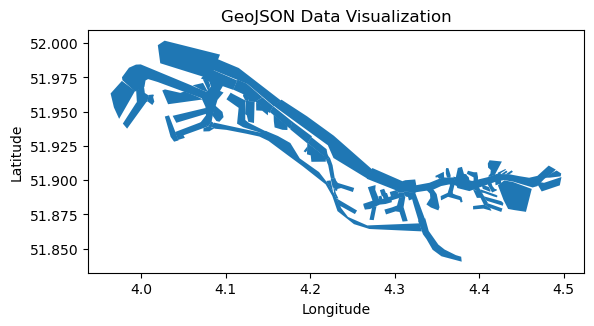

In [35]:
# Load the GeoJSON data from your file
file_path = 'Rotterdam_data/haven.txt'
#file_path = 'Data/Input_EDA/haven.txt'
gdf_haven = gpd.read_file(file_path)
gdf_haven.dropna(axis=1)

# Plot the GeoDataFrame
gdf_haven.plot()
plt.title('GeoJSON Data Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Visualization of the polygons representing the in-port water

In [36]:
poly_map = folium.Map(
    location=[51.9, 4.2],    
    zoom_start=11
)
gjson = folium.features.GeoJson(gdf_haven).add_to(poly_map)

poly_map


Merge of all the polygons

In [37]:
#Merge of the polygons
merged_haven = unary_union(gdf_haven['geometry'])

poly_map = folium.Map(
    location=[51.9, 4.2],    
    zoom_start=11
)
gjson = folium.features.GeoJson(merged_haven).add_to(poly_map)

poly_map


As evident from the preceding map, the boundaries are somewhat ambiguous, with a substantial portion of land appearing as water (a closer look will reveal this). Consequently, we made the determination to seek more accurate data. A team member took the initiative to meticulously delineate all the coastlines within the Port of Rotterdam manually. This endeavor has enabled us to establish more accurate distinctions for the water boundaries.

In [38]:
merged_haven = unary_union(gdf_haven['geometry'])

gdf_coast = gpd.read_file('Data/Input_EDA/NL_Waterline.gml', driver='GML')

In [39]:
# Define the custom coordinate system (modify this with your actual custom CRS)
input_crs = "EPSG:28992"

# Define the target EPSG:4326 CRS
target_crs = "EPSG:4326"

# Create a GeoDataFrame and set the custom CRS
gdf_coast.set_crs(input_crs, allow_override=True, inplace=True)

# Transform the geometries to EPSG:4326
gdf_coast = gdf_coast.to_crs(target_crs)


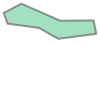

In [40]:
p1 = Point(51.91865, 3.92079)
p2 = Point(51.99519, 3.89333)
p3 = Point(52.0611, 4.01894)
p4 = Point(51.93935, 4.29704)
p5 = Point(51.94185, 4.53538)
p6 = Point(51.84609, 4.5546)
p7 = Point(51.81044, 4.28269)
p8 = Point(51.88806, 4.14468)
points = [p1, p2, p3, p4, p5, p6, p7, p8, p1]

big_area = Polygon([[p.y, p.x] for p in points])
big_area

In [41]:
heaven_and_sea = unary_union((merged_haven,gdf_coast.head(1)['geometry'][0]))
polygon_gdf = gpd.GeoDataFrame(geometry=[heaven_and_sea], crs=gdf_coast.crs)
intersection = gpd.clip(gdf_coast, polygon_gdf)
intersection = intersection[(intersection.geom_type == 'Polygon') | (intersection.geom_type == 'MultiPolygon')]
intersection = intersection[intersection.functie != 'waterzuivering']
intersection = intersection[(intersection.typeWater == 'waterloop') | (intersection.typeWater == 'zee')]
geometry_counts = intersection['typeWater'].value_counts()

intersection_union = unary_union(intersection['geometry'])

Our proposed approach entails delineating the polygon encapsulating the entire water expanse within the Port of Rotterdam into discrete smaller squares. The modification of the square size is a critical parameter ("diagonal_length_meters") that requires careful evaluation of the available processing resources. It is crucial to find the ideal balance between computational viability and accuracy. Although increasing the number of smaller squares improves the discretization's granularity, it is crucial to recognise the computing limitations. An overabundance of detail could impose a strain on the computational infrastructure and hinder the effectiveness of the model. Therefore, it's crucial to make a wise trade-off that balances our available computational resources with precision's smooth integration into the predictive model. 
You can find below the process of discretizing the Polygone that we just created with the new and better coastal boarders.

In [42]:
# The original polygon
original_polygon = gpd.GeoDataFrame(geometry=[big_area], crs=gdf_coast.crs)

# Define the diagonal length for each grid cell in meters (500 meters)
diagonal_length_meters = 1000.0

# Convert diagonal length from meters to degrees
def meters_to_degrees(meters):
    # Earth's radius in meters (approximately)
    earth_radius_meters = 6371000.0
    # Calculate the conversion factor from meters to degrees
    degrees_per_radian = 180.0 / np.pi
    radians_per_degree = np.pi / 180.0
    return (meters / earth_radius_meters) * degrees_per_radian

diagonal_length_degrees = meters_to_degrees(diagonal_length_meters)

# Calculate the size of each grid cell
cell_size = diagonal_length_degrees / np.sqrt(2)

# Get the bounding box of the original polygon
bbox = original_polygon.total_bounds  # Returns [minx, miny, maxx, maxy]

# Create a grid of points within the bounding box
x_min, y_min, x_max, y_max = bbox
x_coords = np.arange(x_min, x_max, cell_size)
y_coords = np.arange(y_min, y_max, cell_size)

# Create a list of square polygons as Shapely Polygons
square_polygons = [Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)]) for x in x_coords for y in y_coords]

# Create a GeoDataFrame from the square polygons
grid_gdf = gpd.GeoDataFrame(geometry=square_polygons, crs=original_polygon.crs)



In [43]:
# Filter the grid polygons to keep only those within the original polygon
grid_within_polygon = grid_gdf[grid_gdf.intersects(original_polygon.unary_union)]
grid_within_polygon.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2064 entries, 26 to 4130
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  2064 non-null   geometry
dtypes: geometry(1)
memory usage: 32.2 KB


In [44]:
grid_within_polygon = gpd.clip(grid_within_polygon, intersection)
grid_within_polygon.reset_index(inplace = True)
grid_within_polygon.rename(columns={"index": "area_ID"}, inplace = True)

The final grid can be visualized below. This is the grid that is going to be used for the predictions method.

In [45]:
poly_map = folium.Map(
    location=[51.9, 4.2],    
    zoom_start=11
)

folium.features.GeoJson(grid_within_polygon).add_to(poly_map) 

poly_map

**Data Processing: the tugs and vessels information**

This stage holds paramount importance for the progression of the project. Here, our main goal is to carefully clean and prepare the several dataframes that are needed in order to use the prediction techniques. It is necessary to recognise that the data that has been supplied is inadequate and inappropriate for our needs at this time. A great deal of work has gone into fixing the numerous problems that the datasets include. Given the sheer enormity of some datasets (ais data sets), a specialized tool in the realm of data science was employed to streamline part of the data processing. This concerns the data about the vessels ( dimensions: lenght and width, draught, and type). This tool, known as ... , proved instrumental in handling the intricacies of large datasets efficiently.  + DESCRIPTION OF ... The decision to opt for this tool was driven by the extensive time required to load the data for each month when utilizing Python on our computers. Due to this extended period, we decided to utilise the knowledge of a team member who had previously worked with ... .

Furthermore, it is important to mention that after a discussion with the employees of Kotug, only the first pick-up and the last drop-off locations have to be predicted. This means that if many tugs help a vessel, only the first one that pick-up and the last one to drop-off will be predicted.

In [46]:
# Create empty lists to store tugs data and their original JSON index
tugs_data = []
trip_ID = []
vessel_name = []  # Create a list to store previous vessel names
vessel_mmsi = []  # Create a list to store previous vessel names


# Extract tugs data into a separate list, store their original index, and the previous vessel name
for i, item in enumerate(tow_data):
    for tug in item['tugs']:
        tugs_data.append(tug)
        trip_ID.append(i)
        vessel_name.append(item['vessel']['name'])
        vessel_mmsi.append(item['vessel']['mmsi'])


# Create a DataFrame for tugs data with the original index and previous vessel name
tugs_df = pd.DataFrame(tugs_data)
tugs_df['trip_ID'] = trip_ID  # Add original index as a new column
tugs_df['vessel_name'] = vessel_name  # Add vessel name as a new column
tugs_df['vessel_mmsi'] = vessel_mmsi

tugs_df['from'] = pd.to_datetime(tugs_df['from'],format='ISO8601')
tugs_df['to'] = pd.to_datetime(tugs_df['to'],format='ISO8601')

tugs_df['from_rounded'] = tugs_df['from'].dt.round('H')
tugs_df['to_rounded'] = tugs_df['to'].dt.round('H')

# Create a DataFrame for the rest of the data (excluding tugs)
vessel_info = [{'from': item['from'],
               'to': item['to'],
               'vessel': item['vessel'],
               'type': item['type'],
               'additional_data': item['additional_data']}
              for item in tow_data]

vessel_df = pd.DataFrame(vessel_info)

tugs_df = tugs_df.merge(vessel_df['type'], left_on='trip_ID', right_index=True)

Addition of the weather data (direction of the wind and wind speed)
We categorized them in excel, i order to be able to use them in the prediction model.

In [47]:
wind = pd.read_csv('Data/Input_EDA/Weather.csv')
wind['Datetime'] =  pd.to_datetime(wind['Datetime'])
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8808 entries, 0 to 8807
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   # STN       8808 non-null   int64              
 1   YYYYMMDD    8808 non-null   int64              
 2   H           8808 non-null   int64              
 3   Datetime    8808 non-null   datetime64[ns, UTC]
 4      DD       8808 non-null   int64              
 5      FH       8808 non-null   int64              
 6   Direction   8808 non-null   object             
 7   Wind_speed  8808 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(5), object(2)
memory usage: 550.6+ KB


**Vessel data information**

Here you can see the csv files that have been imported from the special tool, after processing the data there.

In [48]:
vessel_size_data = pd.read_csv('Data/Input_EDA/Vessel_size_data.csv')

vessel_draught_data = pd.read_csv('Data/Input_EDA/Vessel-draught_data.csv')


In [49]:
vessel_draught_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307701 entries, 0 to 1307700
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   device_mmsi         1307698 non-null  float64
 1   Navigation_draught  1307696 non-null  float64
 2   DateTime            1307695 non-null  object 
dtypes: float64(2), object(1)
memory usage: 29.9+ MB


In [50]:
vessel_draught_data.dropna(inplace= True)

vessel_draught_data['device_mmsi'] = vessel_draught_data['device_mmsi'].astype(int)
vessel_draught_data['DateTime'] = vessel_draught_data['DateTime'].str.replace('"', '')

vessel_draught_data.head()

,device_mmsi,Navigation_draught,DateTime
0,246367000,3.3,2022-10-19 07:00:00+00:00
1,246367000,3.3,2022-10-19 08:00:00+00:00
2,246367000,3.3,2022-10-19 09:00:00+00:00
3,244660631,2.6,2022-10-09 17:00:00+00:00
4,244660631,2.6,2022-10-09 18:00:00+00:00


In [51]:
vessel_draught_data['DateTime'] = pd.to_datetime(vessel_draught_data['DateTime'], format='ISO8601')

We opted to handle incoming and departing vessels as distinct cases, primarily because the necessary variables vary based on the scenario. For incoming vessels, the pertinent variables include "from" (excluding "to_haven"), whereas for departing vessels, the relevant variables are "to" (excluding "from_haven"). Consequently, we established two separate data frames, each exclusively containing the pertinent data corresponding to its respective case.

## Incoming vessels

In [52]:
tugs_incoming = tugs_df[tugs_df['type']=='incoming']
tugs_incoming = tugs_incoming[['from','from_rounded', 'from_location' ,'to_haven', 'trip_ID', 'vessel_mmsi']]

# Create a Shapely Point geometry from the "from_location" coordinates
tugs_incoming['geometry'] = tugs_incoming['from_location'].apply(lambda coord: Point(coord))

# Convert the DataFrame to a GeoDataFrame
tugs_incoming_gdf = gpd.GeoDataFrame(tugs_incoming, geometry='geometry')
tugs_incoming_gdf = tugs_incoming_gdf.set_crs("EPSG:4326")

In [53]:
incoming_data = gpd.sjoin(grid_within_polygon, tugs_incoming_gdf, how="inner", op="intersects")
incoming_data.sort_values('from', inplace = True)
incoming_data.drop_duplicates(subset = 'trip_ID',keep='first', inplace = True)

incoming_data = incoming_data.merge(wind[['Datetime', 'Direction', 'Wind_speed']], left_on = 'from_rounded', right_on = 'Datetime', how = 'left')

incoming_data.to_csv('Data/Input_ML/incoming_weather.csv')

incoming_data = incoming_data.merge(vessel_size_data, left_on = 'vessel_mmsi', right_on = 'device_mmsi', how = 'inner')

incoming_data.to_csv('Data/Input_ML/incoming_weather_size.csv')

incoming_data = incoming_data.merge(vessel_draught_data, left_on = ['vessel_mmsi','from_rounded'], right_on = ['device_mmsi','DateTime'], how = 'inner')

incoming_data.to_csv('Data/Input_ML/incoming_weather_size_draught.csv')

# incoming_data = incoming_data.merge(vessel_draught_data, left_on = ['vessel_mmsi'], right_on = ['device_mmsi'], how = 'inner')
# incoming_data['time_diff'] = abs(incoming_data['DateTime'] - incoming_data['from_rounded']).dt.total_seconds() / 3600
# min_idx = incoming_data.groupby(['vessel_mmsi','from_rounded'])['time_diff'].idxmin()
# incoming_data = incoming_data.loc[min_idx]

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


## Leaving vessels

In [54]:
tugs_leaving = tugs_df[tugs_df['type']=='leaving']
tugs_leaving = tugs_leaving[['to','to_rounded',	'to_location' ,'from_haven', 'trip_ID', 'vessel_mmsi']]

# Create a Shapely Point geometry from the "from_location" coordinates
tugs_leaving['geometry'] = tugs_leaving['to_location'].apply(lambda coord: Point(coord))

# Convert the DataFrame to a GeoDataFrame
tugs_leaving_gdf = gpd.GeoDataFrame(tugs_leaving, geometry='geometry')
tugs_leaving_gdf = tugs_leaving_gdf.set_crs("EPSG:4326")

In [55]:
leaving_data = gpd.sjoin(grid_within_polygon, tugs_leaving_gdf, how="inner", op="intersects")
leaving_data.sort_values('to', inplace = True)
leaving_data.drop_duplicates(subset = 'trip_ID',keep='last', inplace = True)
leaving_data = leaving_data.merge(wind[['Datetime', 'Direction',	'Wind_speed']], left_on = 'to_rounded', right_on = 'Datetime', how = 'left')

leaving_data.to_csv('Data/Input_ML/leaving_weather.csv')

leaving_data = leaving_data.merge(vessel_size_data, left_on = 'vessel_mmsi', right_on = 'device_mmsi', how = 'inner')

leaving_data.to_csv('Data/Input_ML/leaving_weather_size.csv')

leaving_data = leaving_data.merge(vessel_draught_data, left_on = ['vessel_mmsi','to_rounded'], right_on = ['device_mmsi','DateTime'], how = 'inner')

leaving_data.to_csv('Data/Input_ML/leaving_weather_size_draught.csv')

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


We now possess two primary data frames, namely "leaving_data" and "incoming_data," which will serve as the foundation for our prediction model. These data frames have been meticulously processed and optimized, ensuring their readiness for the most efficient utilization in our analyses.


Finally, you can find below the visualization of a haven and all towages of the incoming tugs (tugs going to this haven). 

In [56]:
selected_haven = '6PET'


# Create a Folium Map
poly_map = folium.Map(
    location=[51.9, 4.2],
    zoom_start=11
)

# Filter the GeoDataFrame for markers with 'to_haven' equal to '7PET'
heaven_gdf = tugs_incoming_gdf[tugs_incoming_gdf['to_haven'] == selected_haven]


filtered_grid = gpd.sjoin(grid_within_polygon, heaven_gdf, how="inner", op="intersects")

#filtered_grid.drop_duplicates(subset='geometry', keep='first', inplace=True, ignore_index=False)

folium.features.GeoJson(filtered_grid['geometry']).add_to(poly_map) 

# Add CircleMarker for each point in the heaven GeoDataFrame
for index, row in heaven_gdf.iterrows():
    folium.CircleMarker(
        location=(row['geometry'].y, row['geometry'].x),  # Swap lat and lon
        radius=3,  # Adjust the radius as needed for the size of the dot
        color='red',  # Dot color
        fill=True,
        fill_color='red',  # Dot fill color
        fill_opacity=0.6,
    ).add_to(poly_map)
    



# Display the map
poly_map


/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [57]:
heaven_gdf

,from,from_rounded,from_location,to_haven,trip_ID,vessel_mmsi,geometry
42,2022-06-01 07:55:24+00:00,2022-06-01 08:00:00+00:00,"[4.07592, 51.97932]",6PET,25,219337000,POINT (4.07592 51.97932)
43,2022-06-01 07:55:08+00:00,2022-06-01 08:00:00+00:00,"[4.07592, 51.97932]",6PET,25,219337000,POINT (4.07592 51.97932)
238,2022-06-03 05:16:27+00:00,2022-06-03 05:00:00+00:00,"[4.08594, 51.97261]",6PET,131,248043000,POINT (4.08594 51.97261)
1066,2022-06-10 09:15:55+00:00,2022-06-10 09:00:00+00:00,"[4.06956, 51.98169]",6PET,595,257983000,POINT (4.06956 51.98169)
1192,2022-06-11 12:33:56+00:00,2022-06-11 13:00:00+00:00,"[4.08335, 51.97528]",6PET,662,248439000,POINT (4.08335 51.97528)
...,...,...,...,...,...,...,...
41322,2023-05-23 14:08:08+00:00,2023-05-23 14:00:00+00:00,"[4.07097, 51.98021]",6PET,23934,311040100,POINT (4.07097 51.98021)
41323,2023-05-23 14:08:07+00:00,2023-05-23 14:00:00+00:00,"[4.07097, 51.98021]",6PET,23934,311040100,POINT (4.07097 51.98021)
41903,2023-05-28 23:09:33+00:00,2023-05-28 23:00:00+00:00,"[4.07022, 51.98057]",6PET,24282,351221000,POINT (4.07022 51.98057)
42076,2023-05-30 14:04:57+00:00,2023-05-30 14:00:00+00:00,"[4.06532, 51.98252]",6PET,24395,563654000,POINT (4.06532 51.98252)


Below is the code that we used before using the special tool. The code was running and working. However, the running time when it came to load more than one month became way too high. So we decided to use another specialized tool.

In [58]:
# def flatten_dict(d, parent_key='', sep='_'):
#     items = {}
#     for k, v in d.items():
#         new_key = f"{parent_key}{sep}{k}" if parent_key else k
#         if isinstance(v, dict):
#             items.update(flatten_dict(v, new_key, sep=sep))
#         else:
#             items[new_key] = v
#     return items


# data = pd.DataFrame()
# for i in range(6,13):
#     # Opening JSON file
#     f = open('Rotterdam_data/ais_rotterdam/ais_rotterdam_'+str(i)+'.json')
    
#     # returns JSON object as a dictionary
#     json_data = json.load(f)
    
#     # Flatten each dictionary and store the results in a list
#     flattened_dicts = [flatten_dict(d) for d in json_data['data']]
    
#     # Create a DataFrame
#     data = pd.concat([data, pd.DataFrame(flattened_dicts)])

# # Closing file
# f.close()

In [59]:
# #data['navigation_destination_eta'] = pd.to_datetime(data['navigation_destination_eta'])
# #data['navigation_time'] = pd.to_datetime(data['navigation_time'])
# # Remove rows where 'vessel_type' is 'tug'
# data = data[data['vessel_type'] != 'tug']
# # Remove the 'vessel_subtype' column
# data = data.drop('vessel_subtype', 'vessel_callsign','navigation_status', 'navigation_destination_eta', 'navigation_heading', 'navigation_time', 'navigation_course', 'navigation_speed	', 'navigation_location_type', 'navigation_location_coordinates')
# #data[['navigation_location_lat', 'navigation_location_long']] = data['navigation_location_coordinates'].apply(lambda x: pd.Series(str(x).strip('[]').split(','))).astype(float)
# data

In [60]:
# columns_to_drop = [
#     'vessel_callsign',
#     'navigation_heading',
#     'navigation_course',
#     'navigation_speed',
#     'navigation_location_type',
# ]

# numeric_columns = [
#     'device_mmsi',
#     'device_dimensions_to_bow',           
#     'device_dimensions_to_stern',       
#     'device_dimensions_to_starboard',     
#     'device_dimensions_to_port',
#     #'vessel_imo'
#     'navigation_draught',
#     #'vessel_type',
#     #'vessel_subtype'
# ]

# info_columns = [
#     'device_mmsi',
#     'vessel_type',
#     #'vessel_subtype'
# ]

# vessel_size = data[numeric_columns]
# vessel_size = vessel_size.groupby('device_mmsi').median()
# vessel_size['length'] = vessel_size['device_dimensions_to_bow'] + vessel_size['device_dimensions_to_stern']
# vessel_size['width'] = vessel_size['device_dimensions_to_starboard'] + vessel_size['device_dimensions_to_port']
# vessel_size.drop(['device_dimensions_to_bow','device_dimensions_to_stern', 'device_dimensions_to_starboard' ,'device_dimensions_to_port'], axis=1, inplace=True)
# vessel_size.reset_index(inplace=True)

# vessel_info = data[info_columns]

# vessel_info = vessel_info.groupby('device_mmsi').agg(lambda x: x.mode(0))
# vessel_info.reset_index(inplace=True)

# vessel_data = pd.merge(vessel_size,vessel_info)
# vessel_data['vessel_type_Code'], unique_values = pd.factorize(vessel_data['vessel_type'])
# main_db = pd.merge(tugs_dfb,vessel_data,how= 'right',left_on='vessel_mmsi',right_on='device_mmsi')
# main_db.dropna(inplace=True)